In [ ]:
import os
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.resnet_v2 import preprocess_input
from tensorflow.keras import models, layers
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import tensorflow as tf
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import shutil
import json

In [2]:
def load_dataset(dataset_path):
    images = []
    labels = []
    for classfolder in os.listdir(dataset_path):
        subclassfolder = os.path.join(dataset_path, classfolder)
        for image_filename in os.listdir(subclassfolder):
            image_path = os.path.join(subclassfolder, image_filename)
            images.append(image_path)
            labels.append(classfolder)
    df = pd.DataFrame({'image': images, 'label': labels})
    return df

In [3]:
PATH_DATASET_ORI = "../PlantVillage/color/"
PATH_DATASET_AUG_1 = "../PlantVillage/augmented_1/"
PATH_DATASET_AUG_2 = "../PlantVillage/augmented_2/"

In [4]:
data = load_dataset(PATH_DATASET_ORI)
data.head()

,image,label
0,./PlantVillage/color/Apple___Apple_scab\00075a...,Apple___Apple_scab
1,./PlantVillage/color/Apple___Apple_scab\01a663...,Apple___Apple_scab
2,./PlantVillage/color/Apple___Apple_scab\01f3de...,Apple___Apple_scab
3,./PlantVillage/color/Apple___Apple_scab\0208f4...,Apple___Apple_scab
4,./PlantVillage/color/Apple___Apple_scab\023123...,Apple___Apple_scab


In [5]:
dataset_aug_1 = load_dataset(PATH_DATASET_AUG_1)
dataset_aug_2 = load_dataset(PATH_DATASET_AUG_2)
print(dataset_aug_1.head())
print(dataset_aug_2.head())

                                               image               label
0  ./PlantVillage/augmented_1/Apple___Apple_scab\...  Apple___Apple_scab
1  ./PlantVillage/augmented_1/Apple___Apple_scab\...  Apple___Apple_scab
2  ./PlantVillage/augmented_1/Apple___Apple_scab\...  Apple___Apple_scab
3  ./PlantVillage/augmented_1/Apple___Apple_scab\...  Apple___Apple_scab
4  ./PlantVillage/augmented_1/Apple___Apple_scab\...  Apple___Apple_scab
                                               image               label
0  ./PlantVillage/augmented_2/Apple___Apple_scab\...  Apple___Apple_scab
1  ./PlantVillage/augmented_2/Apple___Apple_scab\...  Apple___Apple_scab
2  ./PlantVillage/augmented_2/Apple___Apple_scab\...  Apple___Apple_scab
3  ./PlantVillage/augmented_2/Apple___Apple_scab\...  Apple___Apple_scab
4  ./PlantVillage/augmented_2/Apple___Apple_scab\...  Apple___Apple_scab


#### Train Val Test 1 (Augmentation 1)

In [6]:
X_train_1, X_temp_1, y_train_1, y_temp_1 = train_test_split(dataset_aug_1['image'], dataset_aug_1['label'], test_size=0.2, random_state=42,shuffle=True,stratify=dataset_aug_1['label'])
X_val_1, X_test_1, y_val_1, y_test_1 = train_test_split(X_temp_1,y_temp_1, test_size=0.5, random_state=42,shuffle=True,stratify=y_temp_1)
df_train_1 = pd.DataFrame({'image': X_train_1, 'label': y_train_1})
df_test_1 = pd.DataFrame({'image': X_test_1, 'label': y_test_1})
df_val_1 = pd.DataFrame({'image': X_val_1, 'label': y_val_1})

#### Train Val Test 2 (Augmentation 2)

In [7]:
X_train_2, X_temp_2, y_train_2, y_temp_2 = train_test_split(dataset_aug_2['image'], dataset_aug_2['label'], test_size=0.2, random_state=42,shuffle=True,stratify=dataset_aug_2['label'])
X_val_2, X_test_2, y_val_2, y_test_2 = train_test_split(X_temp_2,y_temp_2, test_size=0.5, random_state=42,shuffle=True,stratify=y_temp_2)
df_train_2 = pd.DataFrame({'image': X_train_2, 'label': y_train_2})
df_test_2 = pd.DataFrame({'image': X_test_2, 'label': y_test_2})
df_val_2 = pd.DataFrame({'image': X_val_2, 'label': y_val_2})

In [8]:
df_test_1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3943 entries, 31164 to 14305
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   image   3943 non-null   object
 1   label   3943 non-null   object
dtypes: object(2)
memory usage: 92.4+ KB


In [9]:
dist_data = data['label'].value_counts()
dist_data

label
Orange___Haunglongbing_(Citrus_greening)              5507
Tomato___Tomato_Yellow_Leaf_Curl_Virus                5357
Soybean___healthy                                     5090
Peach___Bacterial_spot                                2297
Tomato___Bacterial_spot                               2127
Tomato___Late_blight                                  1909
Squash___Powdery_mildew                               1835
Tomato___Septoria_leaf_spot                           1771
Tomato___Spider_mites Two-spotted_spider_mite         1676
Apple___healthy                                       1645
Tomato___healthy                                      1591
Blueberry___healthy                                   1502
Pepper,_bell___healthy                                1478
Tomato___Target_Spot                                  1404
Grape___Esca_(Black_Measles)                          1383
Corn_(maize)___Common_rust_                           1192
Grape___Black_rot                                 

In [10]:
print(len(dist_data))
dist_data.index.get_loc('Tomato___Tomato_Yellow_Leaf_Curl_Virus')

38


1

In [11]:
# label_thous = dist_data[dist_data>630].index
# label_thous

In [12]:
label = [0]*len(dist_data)
label[dist_data.index.get_loc('Tomato___Tomato_Yellow_Leaf_Curl_Virus')] = 1
label

[0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0]

In [13]:
# def custom_generator(dataframe, datagen_aug, datagen_non, target_size, batch_size=32):
#     img_batch = []
#     img_label = []
#     for index, row in dataframe.iterrows():
#         label = [0]*len(dist_data)
#         img = load_img(row['image'], target_size=target_size)  # Load gambar
#         img_array = img_to_array(img)  # Konversi ke array
#         img_array = np.expand_dims(img_array, axis=0)

#         # Augmenting images for labels with 1000 images because we didn't add images with 1000 images before
#         if row['label'] in label_thous:
#             # print("augmenting")
#             for batch in datagen_aug.flow(img_array, batch_size=1): # batch shape (1, 256, 256, 3)
#                 aug_img_array = batch[0]                            # Take the first image from the batch
#                 break
#             # or
#             # aug_img_array = next(datagen.flow(img_array, batch_size=1))
#         else:
#             # print("non augmenting")
#             for batch in datagen_non.flow(img_array, batch_size=1):
#                 aug_img_array = batch[0] # Take the first image from the batch
#                 break  # not augmenting image
        
#         label[dist_data.index.get_loc(row['label'])] = 1
#         img_batch.append(aug_img_array)
#         img_label.append(label)
        
#         if len(img_batch) == batch_size:
#             yield (np.array(img_batch), np.array(img_label))
#             img_batch = []
#             img_label = []
            
#     if len(img_batch) > 0:
#         yield (np.array(img_batch), np.array(img_label))

In [14]:
# help(ImageDataGenerator)

In [15]:
# datagen = ImageDataGenerator(
#     rescale=1.0/255
# )

# help(datagen.flow_from_dataframe)

### With Data Augmentation Again

In [16]:
# image_size = (256, 512)
# batch_size = 32

# datagen = ImageDataGenerator(
#     rescale=1.0/255
# )

# # First Augmentation
# datagen_aug_1 = ImageDataGenerator(
#     rescale=1.0/255, 
#     rotation_range=30,
#     width_shift_range=0.1,
#     height_shift_range=0.1,
#     shear_range=0.2,
#     zoom_range=0.2,
#     horizontal_flip=True,
#     vertical_flip=True,
#     fill_mode='nearest'
# )

# # Second Augmentation
# datagen_aug_2 = ImageDataGenerator(
#     rescale=1.0/255, 
#     rotation_range=30,
#     # width_shift_range=0.1,
#     # height_shift_range=0.1,
#     # shear_range=0.2,
#     # zoom_range=0.2,
#     horizontal_flip=True,
#     vertical_flip=True,
#     fill_mode='nearest'
# )

# train_generator_aug_1 = custom_generator(df_train_1, datagen_aug_1,datagen, image_size, batch_size)
# test_generator_aug_1 = custom_generator(df_test_1, datagen_aug_1,datagen, image_size, batch_size)
# val_generator_aug_1 = custom_generator(df_val_1, datagen_aug_1,datagen, image_size, batch_size)

# train_generator_aug_2 = custom_generator(df_train_2, datagen_aug_2,datagen, image_size, batch_size)
# test_generator_aug_2 = custom_generator(df_test_2, datagen_aug_2,datagen, image_size, batch_size)
# val_generator_aug_2 = custom_generator(df_val_2, datagen_aug_2,datagen, image_size, batch_size)

In [ ]:
IMAGE_HEIGHT = 224
IMAGE_WIDTH = 224
CHANNEL = 3

image_size = (IMAGE_HEIGHT, IMAGE_WIDTH)
batch_size = 32

datagen = ImageDataGenerator(
    # rescale=1.0/255,
    preprocessing_function=preprocess_input
)

# First Augmentation
datagen_aug_1 = ImageDataGenerator(
    # rescale=1.0/255,
    preprocessing_function=preprocess_input,
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

# Second Augmentation
datagen_aug_2 = ImageDataGenerator(
    # rescale=1.0/255,
    preprocessing_function=preprocess_input,
    rotation_range=30,
    # width_shift_range=0.1,
    # height_shift_range=0.1,
    # shear_range=0.2,
    # zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

train_generator_aug_1 = datagen_aug_1.flow_from_dataframe(
    df_train_1,
    x_col='image',
    y_col='label',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True,
    seed=42
)

test_generator_1 = datagen.flow_from_dataframe( # For Augmentation again and not_1
    df_test_1,
    x_col='image',
    y_col='label',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

val_generator_1 = datagen.flow_from_dataframe( # For Augmentation again and not_1
    df_val_1,
    x_col='image',
    y_col='label',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

train_generator_aug_2 = datagen_aug_2.flow_from_dataframe(
    df_train_2,
    x_col='image',
    y_col='label',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True,
    seed=42
)

test_generator_2 = datagen.flow_from_dataframe( # For Augmentation again and not_2
    df_test_2,
    x_col='image',
    y_col='label',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

val_generator_2 = datagen.flow_from_dataframe( # For Augmentation again and not_2
    df_val_2,
    x_col='image',
    y_col='label',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 31543 validated image filenames belonging to 38 classes.
Found 3943 validated image filenames belonging to 38 classes.
Found 3943 validated image filenames belonging to 38 classes.
Found 31543 validated image filenames belonging to 38 classes.
Found 3943 validated image filenames belonging to 38 classes.
Found 3943 validated image filenames belonging to 38 classes.


In [ ]:
CLASS_NAMES = list(train_generator_aug_1.class_indices.keys())

if not os.path.exists('Saved_models'):
    os.makedirs('Saved_models')
    
with open('Saved_models/class_names.json', 'w') as f:
    json.dump(CLASS_NAMES, f)

with open("Saved_models/class_names.json", "r") as f:
    CLASS_NAMES = json.load(f)
# CLASS_NAMES

In [18]:
# train_generator_aug_1.reset()
for _, labels in train_generator_aug_1:
    print(np.argmax(labels, axis=1))
    break

[17  1 23 22  4 33  4 28 35 13 34 27 28 24 11  9  7  1 31 22 25 25 19 21
  5 25 25  1  6 13 37  5]


In [19]:
# test_generator_1.reset()
for _, labels in test_generator_1:
    print(np.argmax(labels,axis=1))
    break

[29 29  6 25 26 24  0  1 36 27 27  7 21 21  5 36 31 15 10  5 18  0 34 27
 11  6  9 34 10 23 18 36]


In [20]:
# test_generator_1.reset()
for _, labels in test_generator_1:
    print(np.argmax(labels,axis=1))
    break

[ 4 17  0 35 25 19  1 28 37 13 22  6 31 19 23 20  1 36  1  8 22 21  7 11
 22 18 13  6 17 13 34 31]


In [21]:
df_test_1.shape[0]

3943

In [22]:
df_test_1['label'].value_counts()

label
Strawberry___healthy                                  137
Grape___healthy                                       127
Apple___Apple_scab                                    126
Apple___Black_rot                                     124
Tomato___Tomato_mosaic_virus                          112
Raspberry___healthy                                   111
Apple___Cedar_apple_rust                              110
Peach___healthy                                       108
Potato___healthy                                      107
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot    102
Soybean___healthy                                     100
Corn_(maize)___Common_rust_                           100
Tomato___healthy                                      100
Grape___Leaf_blight_(Isariopsis_Leaf_Spot)            100
Potato___Early_blight                                 100
Tomato___Septoria_leaf_spot                           100
Grape___Esca_(Black_Measles)                          100
Pepper,_

In [23]:
from collections import Counter

counter = Counter()
count=1
for _, labels in test_generator_1:
    # print(np.argmax(labels, axis=1))
    counter.update(np.argmax(labels, axis=1))
    if count==(np.ceil(df_test_1.shape[0]/batch_size))*1:
        break
    count+=1
    # if sum(counter.values()) == df_test_1.shape[0]:
    #     break
counter, sum(counter.values())

(Counter({27: 137,
          14: 127,
          0: 126,
          1: 124,
          36: 112,
          23: 111,
          2: 110,
          17: 108,
          22: 107,
          7: 102,
          13: 100,
          4: 100,
          21: 100,
          35: 100,
          11: 100,
          26: 100,
          19: 100,
          37: 100,
          12: 100,
          32: 100,
          34: 100,
          24: 100,
          20: 100,
          10: 100,
          33: 100,
          25: 100,
          18: 100,
          16: 100,
          28: 100,
          15: 100,
          30: 100,
          3: 100,
          5: 100,
          29: 100,
          8: 100,
          9: 99,
          31: 95,
          6: 85}),
 3943)

##### So we can use .reset() in test_generator and val_generator for consistent data order, but if we don't use it, it's okay because the distribution of the number of labels will remain the same.

In [24]:
# train_generator_aug_1.class_indices

In [25]:
for (image_batch_1, label_batch_1), (image_batch_2, label_batch_2) in zip(train_generator_aug_1,train_generator_aug_2):
    # print(image_batch.shape)
    break
print("Image batch (1 and 2) shape: ", image_batch_1.shape, image_batch_2.shape)
print("Label batch (1 and 2) shape: ", label_batch_1.shape, label_batch_2.shape)

Image batch (1 and 2) shape:  (32, 224, 224, 3) (32, 224, 224, 3)
Label batch (1 and 2) shape:  (32, 38) (32, 38)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[[[ 0.17187715  0.1405046   0.25815165]
  [-0.04456478 -0.07593733  0.04170978]
  [ 0.11049569  0.07912314  0.19677019]
  ...
  [ 0.5370598   0.5135304   0.5998049 ]
  [ 0.5493895   0.5258601   0.6121346 ]
  [ 0.5590173   0.5354879   0.6217624 ]]

 [[ 0.2957387   0.26436615  0.3820132 ]
  [ 0.0332911   0.00191855  0.11956561]
  [-0.11245525 -0.1438278  -0.02618074]
  ...
  [ 0.5557982   0.53226876  0.61854327]
  [ 0.5504725   0.5269431   0.6132176 ]
  [ 0.5335125   0.50998306  0.59625757]]

 [[ 0.18947732  0.15810478  0.27575183]
  [ 0.15133452  0.11996198  0.23760903]
  [-0.05747724 -0.08884978  0.02879739]
  ...
  [ 0.5419276   0.51839817  0.6046727 ]
  [ 0.5205234   0.4969939   0.5832685 ]
  [ 0.4866035   0.4630741   0.5493486 ]]

 ...

 [[-0.8979573  -0.84305537 -0.9163672 ]
  [-0.87251735 -0.8176154  -0.9248471 ]
  [-0.8666543  -0.8176254  -0.94507325]
  ...
  [ 0.500234    0.4767046   0.5629791 ]
  [ 0.43027842  0.406749    0.4930235 ]
  [ 0.47571158  0.45218217  0.5384567 ]]

 [

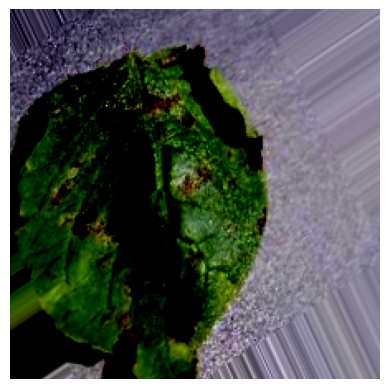

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


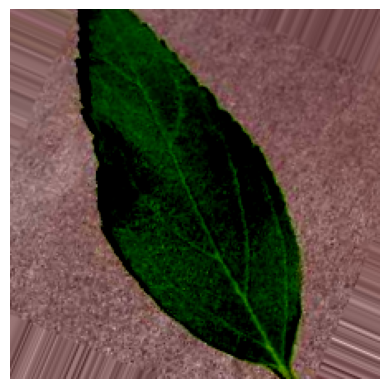

In [31]:
for (image_batch_1, label_batch_1), (image_batch_2, label_batch_2) in zip(train_generator_aug_1,train_generator_aug_2):
    for image in image_batch_1:
        print(image)
        plt.imshow(image)
        plt.axis('off')
        plt.show()
        break
    for image in image_batch_2:
        plt.imshow(image)
        plt.axis('off')
        plt.show()
        break
    break

In [32]:
type(train_generator_aug_1)

keras.preprocessing.image.DataFrameIterator

### Without Data Augmentation Again

In [33]:
train_generator_1 = datagen.flow_from_dataframe(
    df_train_1,
    x_col='image',
    y_col='label',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True,
    seed=42
)

train_generator_2 = datagen.flow_from_dataframe(
    df_train_2,
    x_col='image',
    y_col='label',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True,
    seed=42
)

Found 31543 validated image filenames belonging to 38 classes.
Found 31543 validated image filenames belonging to 38 classes.


In [34]:
for (image_batch_1, label_batch_1), (image_batch_2, label_batch_2) in zip(train_generator_1,train_generator_2):
    # print(image_batch.shape)
    break
print("Image batch (1 and 2) shape: ", image_batch_1.shape, image_batch_2.shape)
print("Label batch (1 and 2) shape: ", label_batch_1.shape, label_batch_2.shape)

Image batch (1 and 2) shape:  (32, 224, 224, 3) (32, 224, 224, 3)
Label batch (1 and 2) shape:  (32, 38) (32, 38)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


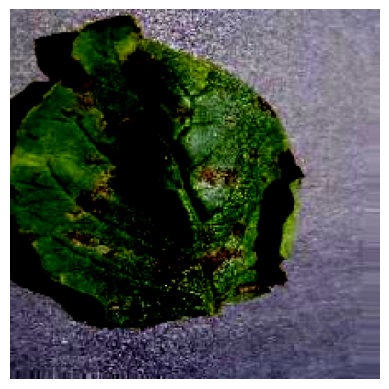

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


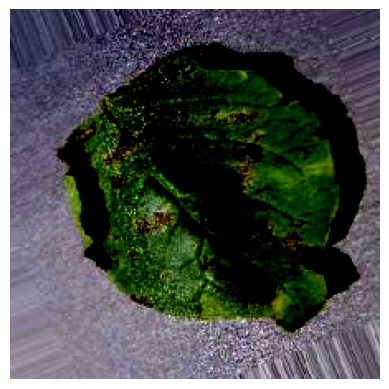

In [40]:
for (image_batch_1, label_batch_1), (image_batch_2, label_batch_2) in zip(train_generator_1,train_generator_2):
    for image in image_batch_1:
        plt.imshow(image)
        plt.axis('off')
        plt.show()
        break
    for image in image_batch_2:
        plt.imshow(image)
        plt.axis('off')
        plt.show()
        break
    break

In [41]:
type(train_generator_1)

keras.preprocessing.image.DataFrameIterator

## Modelling -> ResNet50

In [42]:
# resnet50 = tf.keras.applications.ResNet50(
#     include_top=False,
#     weights='imagenet',
#     input_shape=(224, 224, 3)
# )

# resnet50v2 = tf.keras.applications.ResNet50V2(
#     include_top=False,
#     weights='imagenet',
#     input_shape=(224, 224, 3),
# )

# for layer in resnet50.layers[-4:]:
#     print(layer.name)
# print()
# for layer in resnet50v2.layers[-6:]:
#     print(layer.name)

In [43]:
pretrained_model = tf.keras.applications.ResNet50V2(
    include_top=False,
    input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, CHANNEL),
    weights="imagenet",
    pooling="avg",
    # classes=38
)

for layer in pretrained_model.layers:
    layer.trainable = False

# print(pretrained_model.layers[-14:])

for layer in pretrained_model.layers[-14:]:
    print(layer.name)
    
# print(np.array(pretrained_model.layers[-3].get_weights()).shape)
# for layer in pretrained_model.layers[:7]:
#     print(layer)
# print(pretrained_model.layers[0].input_shape)

for layer in pretrained_model.layers[-14:]:
    layer.trainable = True

# print(pretrained_model.summary())

resnet50v2_aug1 = models.Sequential([
    pretrained_model,
    layers.BatchNormalization(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(38, activation='softmax')
]
)

# print(resnet50v2_aug1.layers[-1],resnet50v2_aug1.layers[-1].trainable)

resnet50v2_aug1.summary()

conv5_block3_preact_bn
conv5_block3_preact_relu
conv5_block3_1_conv
conv5_block3_1_bn
conv5_block3_1_relu
conv5_block3_2_pad
conv5_block3_2_conv
conv5_block3_2_bn
conv5_block3_2_relu
conv5_block3_3_conv
conv5_block3_out
post_bn
post_relu
avg_pool
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 2048)              23564800  
                                                                 
 batch_normalization (BatchN  (None, 2048)             8192      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 256)               524544    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_

In [44]:
# help(EarlyStopping)

In [45]:
epochs = 20
early_patience = 5
reduce_patience = 2
factor = 0.5
min_lr = 1e-5

### Data Augmentation Again - Augmentation 1

In [ ]:
adam = Adam(learning_rate=0.001)
earlystopping = EarlyStopping(monitor='val_loss', patience=early_patience, verbose=1, restore_best_weights=True)
checkpoint = ModelCheckpoint('../Saved_models/_ResNet50V2_aug1.h5', monitor='val_loss', save_best_only=True, verbose=1)
lr_callback = ReduceLROnPlateau(
    monitor='val_loss',
    factor=factor,
    patience=reduce_patience,
    min_lr=min_lr,
    verbose=1
)

resnet50v2_aug1.compile(
    optimizer=adam,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history_aug_1 = resnet50v2_aug1.fit(
    train_generator_aug_1,
    validation_data=val_generator_1,
    epochs=epochs,
    callbacks=[earlystopping, checkpoint, lr_callback]
)

resnet50v2_aug1=models.load_model('../Saved_models/_ResNet50V2_aug1.h5')

Epoch 1/20
986/986 [==============================] - ETA: 0s - loss: 0.8360 - accuracy: 0.7729
Epoch 1: val_loss improved from inf to 0.27286, saving model to Models\ResNet50V2_aug1.h5
986/986 [==============================] - 766s 776ms/step - loss: 0.8360 - accuracy: 0.7729 - val_loss: 0.2729 - val_accuracy: 0.9155 - lr: 0.0010
Epoch 2/20
986/986 [==============================] - ETA: 0s - loss: 0.3959 - accuracy: 0.8851
Epoch 2: val_loss improved from 0.27286 to 0.25033, saving model to Models\ResNet50V2_aug1.h5
986/986 [==============================] - 481s 487ms/step - loss: 0.3959 - accuracy: 0.8851 - val_loss: 0.2503 - val_accuracy: 0.9297 - lr: 0.0010
Epoch 3/20
986/986 [==============================] - ETA: 0s - loss: 0.3363 - accuracy: 0.9010
Epoch 3: val_loss improved from 0.25033 to 0.17669, saving model to Models\ResNet50V2_aug1.h5
986/986 [==============================] - 565s 573ms/step - loss: 0.3363 - accuracy: 0.9010 - val_loss: 0.1767 - val_accuracy: 0.9447 - l

In [47]:
# help(resnet50v2.evaluate)

In [48]:
eval = resnet50v2_aug1.evaluate(test_generator_1)
print("Data Augmentation Again - Augmentation 1 Accuracy: ", eval[1])
print("Data Augmentation Again - Augmentation 1 Loss: ", eval[0])

124/124 [==============================] - 36s 289ms/step - loss: 0.0623 - accuracy: 0.9838
Data Augmentation Again - Augmentation 1 Accuracy:  0.9837687015533447
Data Augmentation Again - Augmentation 1 Loss:  0.062326978892087936


In [49]:
# Reused because each experiment used the same
y_true_1 = test_generator_1.classes
y_true_2 = test_generator_2.classes

In [50]:
y_pred = resnet50v2_aug1.predict(test_generator_1)
y_pred_aug1 = np.argmax(y_pred, axis=1)
print(f"Pred: {y_pred_aug1[5:10]}")
print(f"True: {np.array(y_true_1)[5:10]}")

124/124 [==============================] - 7s 51ms/step
Pred: [24  0  1 36 27]
True: [24  0  1 36 27]


### Data Augmentation Again - Augmentation 2

In [ ]:
pretrained_model = tf.keras.applications.ResNet50V2(
    include_top=False,
    input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, CHANNEL),
    weights="imagenet",
    pooling="avg"
)

for layer in pretrained_model.layers:
    layer.trainable = False

for layer in pretrained_model.layers[-14:]:
    layer.trainable = True

resnet50v2_aug2 = models.Sequential([
    pretrained_model,
    layers.BatchNormalization(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(38, activation='softmax')
]
)

# print(resnet50v2_aug2.summary())

adam = Adam(learning_rate=0.001)
earlystopping = EarlyStopping(monitor='val_loss', patience=early_patience, verbose=1, restore_best_weights=True)
checkpoint = ModelCheckpoint('../Saved_models/_ResNet50V2_aug2.h5', monitor='val_loss', save_best_only=True, verbose=1)
lr_callback = ReduceLROnPlateau(
    monitor='val_loss',
    factor=factor,
    patience=reduce_patience,
    min_lr=min_lr,
    verbose=1
)

resnet50v2_aug2.compile(
    optimizer=adam,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history_aug_2 = resnet50v2_aug2.fit(
    train_generator_aug_2,
    validation_data=val_generator_2,
    epochs=epochs,
    callbacks=[earlystopping, checkpoint, lr_callback]
)

resnet50v2_aug2=models.load_model('../Saved_models/_ResNet50V2_aug2.h5')

Epoch 1/20
986/986 [==============================] - ETA: 0s - loss: 0.6868 - accuracy: 0.8121
Epoch 1: val_loss improved from inf to 0.26336, saving model to Models\ResNet50V2_aug2.h5
986/986 [==============================] - 475s 479ms/step - loss: 0.6868 - accuracy: 0.8121 - val_loss: 0.2634 - val_accuracy: 0.9275 - lr: 0.0010
Epoch 2/20
986/986 [==============================] - ETA: 0s - loss: 0.3358 - accuracy: 0.9021
Epoch 2: val_loss improved from 0.26336 to 0.16476, saving model to Models\ResNet50V2_aug2.h5
986/986 [==============================] - 174s 177ms/step - loss: 0.3358 - accuracy: 0.9021 - val_loss: 0.1648 - val_accuracy: 0.9460 - lr: 0.0010
Epoch 3/20
986/986 [==============================] - ETA: 0s - loss: 0.2775 - accuracy: 0.9219
Epoch 3: val_loss improved from 0.16476 to 0.13983, saving model to Models\ResNet50V2_aug2.h5
986/986 [==============================] - 235s 238ms/step - loss: 0.2775 - accuracy: 0.9219 - val_loss: 0.1398 - val_accuracy: 0.9566 - l

In [52]:
eval = resnet50v2_aug2.evaluate(test_generator_2)
print("Data Augmentation Again - Augmentation 2 Accuracy: ", eval[1])
print("Data Augmentation Again - Augmentation 2 Loss: ", eval[0])

124/124 [==============================] - 35s 283ms/step - loss: 0.0659 - accuracy: 0.9848
Data Augmentation Again - Augmentation 2 Accuracy:  0.9847831726074219
Data Augmentation Again - Augmentation 2 Loss:  0.06592416763305664


In [53]:
y_pred = resnet50v2_aug2.predict(test_generator_2)
y_pred_aug2 = np.argmax(y_pred, axis=1)
print(f"Pred: {y_pred_aug2[5:10]}")
print(f"True: {np.array(y_true_2)[5:10]}")

124/124 [==============================] - 7s 53ms/step
Pred: [24  0  1 36 27]
True: [24  0  1 36 27]


### Without Data Augmentation Again -  Augmentation 1

In [54]:
# help(EarlyStopping)

In [ ]:
pretrained_model = tf.keras.applications.ResNet50V2(
    include_top=False,
    input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, CHANNEL),
    weights="imagenet",
    pooling="avg"
)

for layer in pretrained_model.layers:
    layer.trainable = False

for layer in pretrained_model.layers[-14:]:
    layer.trainable = True

resnet50v2_without_aug1 = models.Sequential([
    pretrained_model,
    layers.BatchNormalization(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(38, activation='softmax')
]
)

# print(resnet50v2_without_aug1.summary())

adam = Adam(learning_rate=0.001)
earlystopping = EarlyStopping(monitor='val_loss', patience=early_patience, verbose=1, restore_best_weights=True)
checkpoint = ModelCheckpoint('../Saved_models/_ResNet50V2_without_aug1.h5', monitor='val_loss', save_best_only=True, verbose=1)
lr_callback = ReduceLROnPlateau(
    monitor='val_loss',
    factor=factor,
    patience=reduce_patience,
    min_lr=min_lr,
    verbose=1
)

resnet50v2_without_aug1.compile(
    optimizer=adam,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history_without_aug1 = resnet50v2_without_aug1.fit(
    train_generator_1,
    validation_data=val_generator_1,
    epochs=epochs,
    callbacks=[earlystopping, checkpoint, lr_callback]
)

resnet50v2_without_aug1=models.load_model('../Saved_models/_ResNet50V2_without_aug1.h5')

Epoch 1/20
986/986 [==============================] - ETA: 0s - loss: 0.7279 - accuracy: 0.8037
Epoch 1: val_loss improved from inf to 0.35627, saving model to Models\ResNet50V2_without_aug1.h5
986/986 [==============================] - 66s 65ms/step - loss: 0.7279 - accuracy: 0.8037 - val_loss: 0.3563 - val_accuracy: 0.9049 - lr: 0.0010
Epoch 2/20
986/986 [==============================] - ETA: 0s - loss: 0.3060 - accuracy: 0.9113
Epoch 2: val_loss improved from 0.35627 to 0.19944, saving model to Models\ResNet50V2_without_aug1.h5
986/986 [==============================] - 64s 65ms/step - loss: 0.3060 - accuracy: 0.9113 - val_loss: 0.1994 - val_accuracy: 0.9394 - lr: 0.0010
Epoch 3/20
986/986 [==============================] - ETA: 0s - loss: 0.2239 - accuracy: 0.9342
Epoch 3: val_loss did not improve from 0.19944
986/986 [==============================] - 65s 65ms/step - loss: 0.2239 - accuracy: 0.9342 - val_loss: 0.2183 - val_accuracy: 0.9409 - lr: 0.0010
Epoch 4/20
986/986 [=======

In [56]:
eval = resnet50v2_without_aug1.evaluate(test_generator_1)
print("Without Data Augmentation Again - Augmentation 1 Accuracy: ", eval[1])
print("Without Data Augmentation Again - Augmentation 1 Loss: ", eval[0])

124/124 [==============================] - 7s 53ms/step - loss: 0.1522 - accuracy: 0.9713
Without Data Augmentation Again - Augmentation 1 Accuracy:  0.971341609954834
Without Data Augmentation Again - Augmentation 1 Loss:  0.15219004452228546


In [57]:
y_pred = resnet50v2_without_aug1.predict(test_generator_1)
y_pred_without_aug1 = np.argmax(y_pred, axis=1)
print(f"Pred: {y_pred_without_aug1[5:10]}")
print(f"True: {np.array(y_true_1)[5:10]}")

124/124 [==============================] - 7s 50ms/step
Pred: [24  0  1 36 27]
True: [24  0  1 36 27]


### Without Data Augmentation Again -  Augmentation 2

In [ ]:
pretrained_model = tf.keras.applications.ResNet50V2(
    include_top=False,
    input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, CHANNEL),
    weights="imagenet",
    pooling="avg"
)

for layer in pretrained_model.layers:
    layer.trainable = False

for layer in pretrained_model.layers[-14:]:
    layer.trainable = True

resnet50v2_without_aug2 = models.Sequential([
    pretrained_model,
    layers.BatchNormalization(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(38, activation='softmax')
]
)

# print(resnet50v2_without_aug2.summary())

adam = Adam(learning_rate=0.001)
earlystopping = EarlyStopping(monitor='val_loss', patience=early_patience, verbose=1, restore_best_weights=True)
checkpoint = ModelCheckpoint('../Saved_models/_ResNet50V2_without_aug2.h5', monitor='val_loss', save_best_only=True, verbose=1)
lr_callback = ReduceLROnPlateau(
    monitor='val_loss',
    factor=factor,
    patience=reduce_patience,
    min_lr=min_lr,
    verbose=1
)

resnet50v2_without_aug2.compile(
    optimizer=adam,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history_without_aug2 = resnet50v2_without_aug2.fit(
    train_generator_2,
    validation_data=val_generator_2,
    epochs=epochs,
    callbacks=[earlystopping, checkpoint, lr_callback]
)

resnet50v2_without_aug2=models.load_model('../Saved_models/_ResNet50V2_without_aug2.h5')

Epoch 1/20
986/986 [==============================] - ETA: 0s - loss: 0.6651 - accuracy: 0.8191
Epoch 1: val_loss improved from inf to 0.31086, saving model to Models\ResNet50V2_without_aug2.h5
986/986 [==============================] - 66s 65ms/step - loss: 0.6651 - accuracy: 0.8191 - val_loss: 0.3109 - val_accuracy: 0.9133 - lr: 0.0010
Epoch 2/20
986/986 [==============================] - ETA: 0s - loss: 0.2791 - accuracy: 0.9206
Epoch 2: val_loss improved from 0.31086 to 0.17921, saving model to Models\ResNet50V2_without_aug2.h5
986/986 [==============================] - 64s 64ms/step - loss: 0.2791 - accuracy: 0.9206 - val_loss: 0.1792 - val_accuracy: 0.9460 - lr: 0.0010
Epoch 3/20
986/986 [==============================] - ETA: 0s - loss: 0.2023 - accuracy: 0.9425
Epoch 3: val_loss did not improve from 0.17921
986/986 [==============================] - 124s 125ms/step - loss: 0.2023 - accuracy: 0.9425 - val_loss: 0.2198 - val_accuracy: 0.9432 - lr: 0.0010
Epoch 4/20
986/986 [=====

In [59]:
eval = resnet50v2_without_aug2.evaluate(test_generator_2)
print("Without Data Augmentation Again - Augmentation 2 Accuracy: ", eval[1])
print("Without Data Augmentation Again - Augmentation 2 Loss: ", eval[0])

124/124 [==============================] - 19s 131ms/step - loss: 0.1242 - accuracy: 0.9711
Without Data Augmentation Again - Augmentation 2 Accuracy:  0.9710879921913147
Without Data Augmentation Again - Augmentation 2 Loss:  0.12415727227926254


In [60]:
y_pred = resnet50v2_without_aug2.predict(test_generator_2)
y_pred_without_aug2 = np.argmax(y_pred, axis=1)
print(f"Pred: {y_pred_without_aug2[5:10]}")
print(f"True: {np.array(y_true_2)[5:10]}")

124/124 [==============================] - 18s 129ms/step
Pred: [24  0  1 36 27]
True: [24  0  1 36 27]


## Evaluate Model

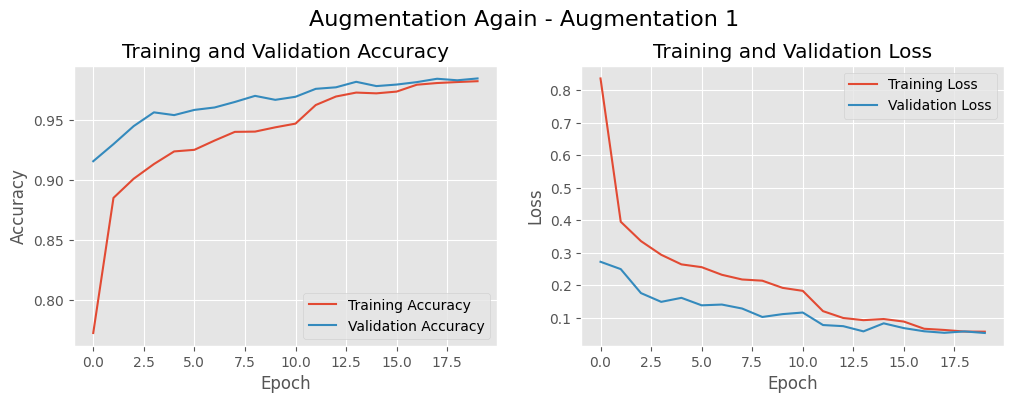

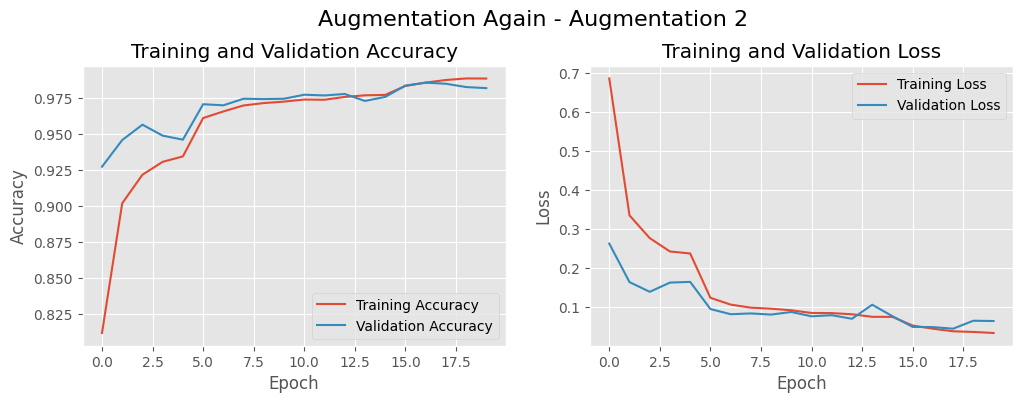

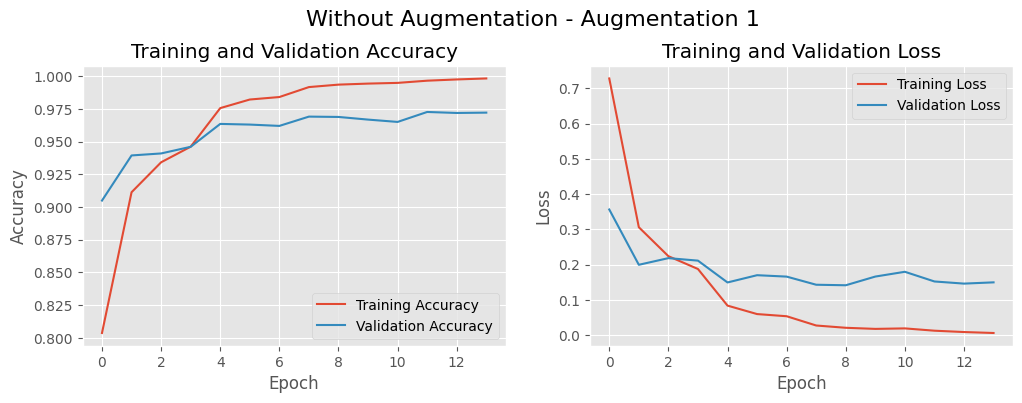

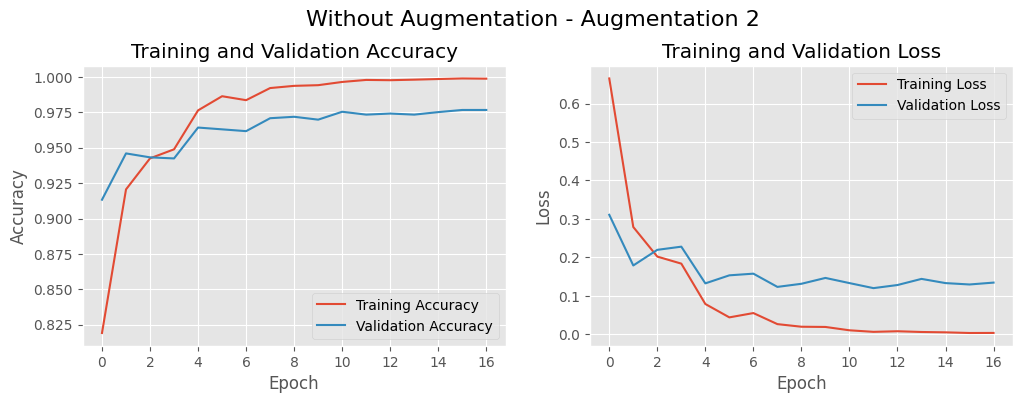

In [61]:
# Plotting
def plot_history(history, title):
    plt.figure(figsize=(12, 8))
    plt.style.use('ggplot')
    plt.suptitle(title, fontsize=16, y=0.95)
    
    plt.subplot(2, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(2, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.show()

plot_history(history_aug_1, "Augmentation Again - Augmentation 1")
plot_history(history_aug_2, "Augmentation Again - Augmentation 2")
plot_history(history_without_aug1, "Without Augmentation - Augmentation 1")
plot_history(history_without_aug2, "Without Augmentation - Augmentation 2")

### Confusion Matrix and Classification Report

In [62]:
test_generator_1.reset()

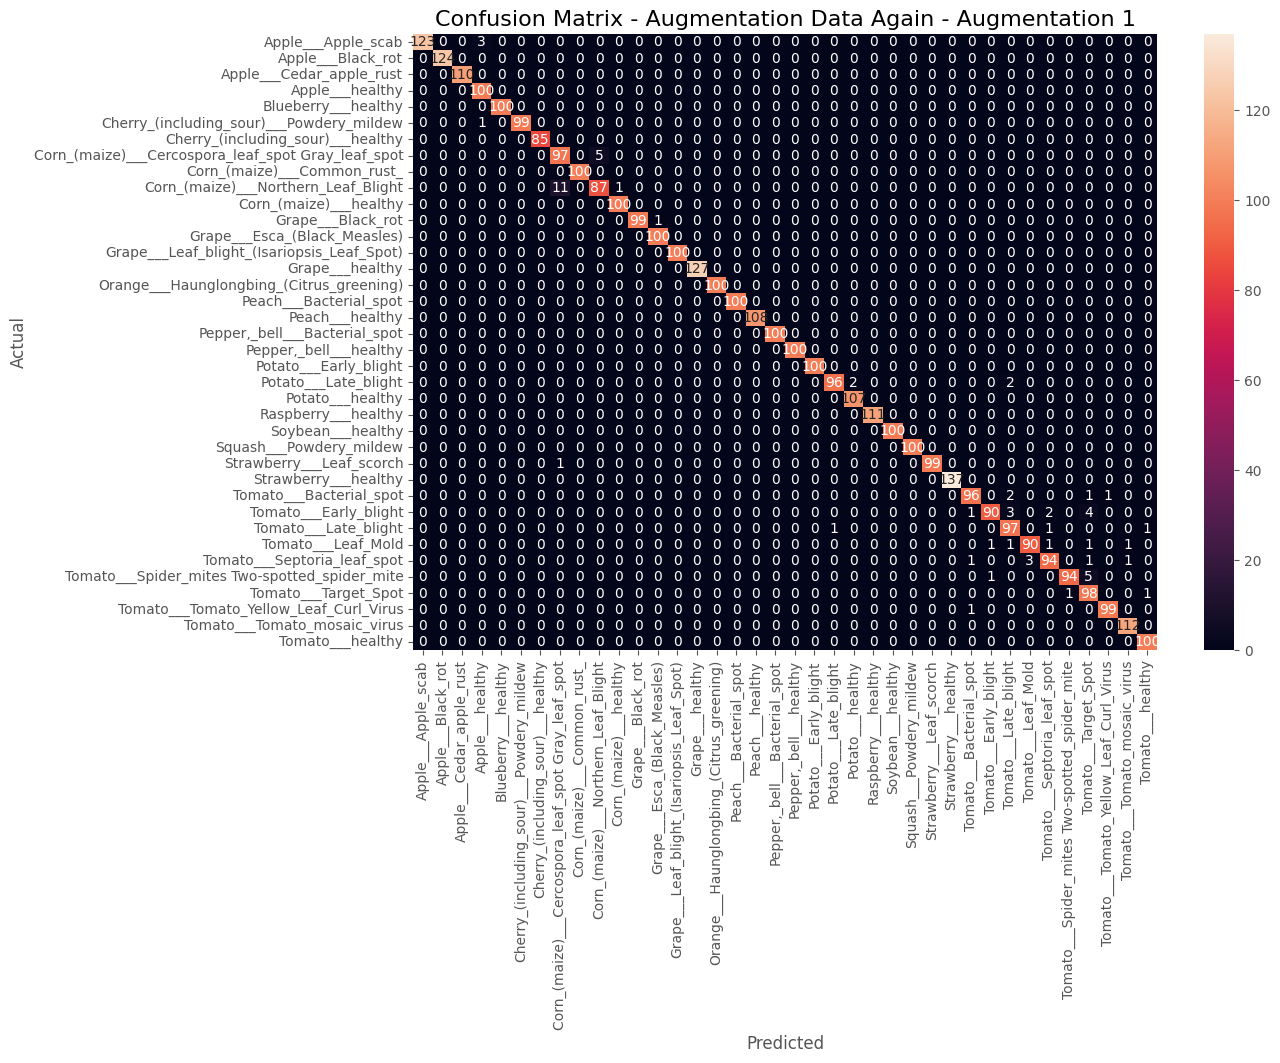

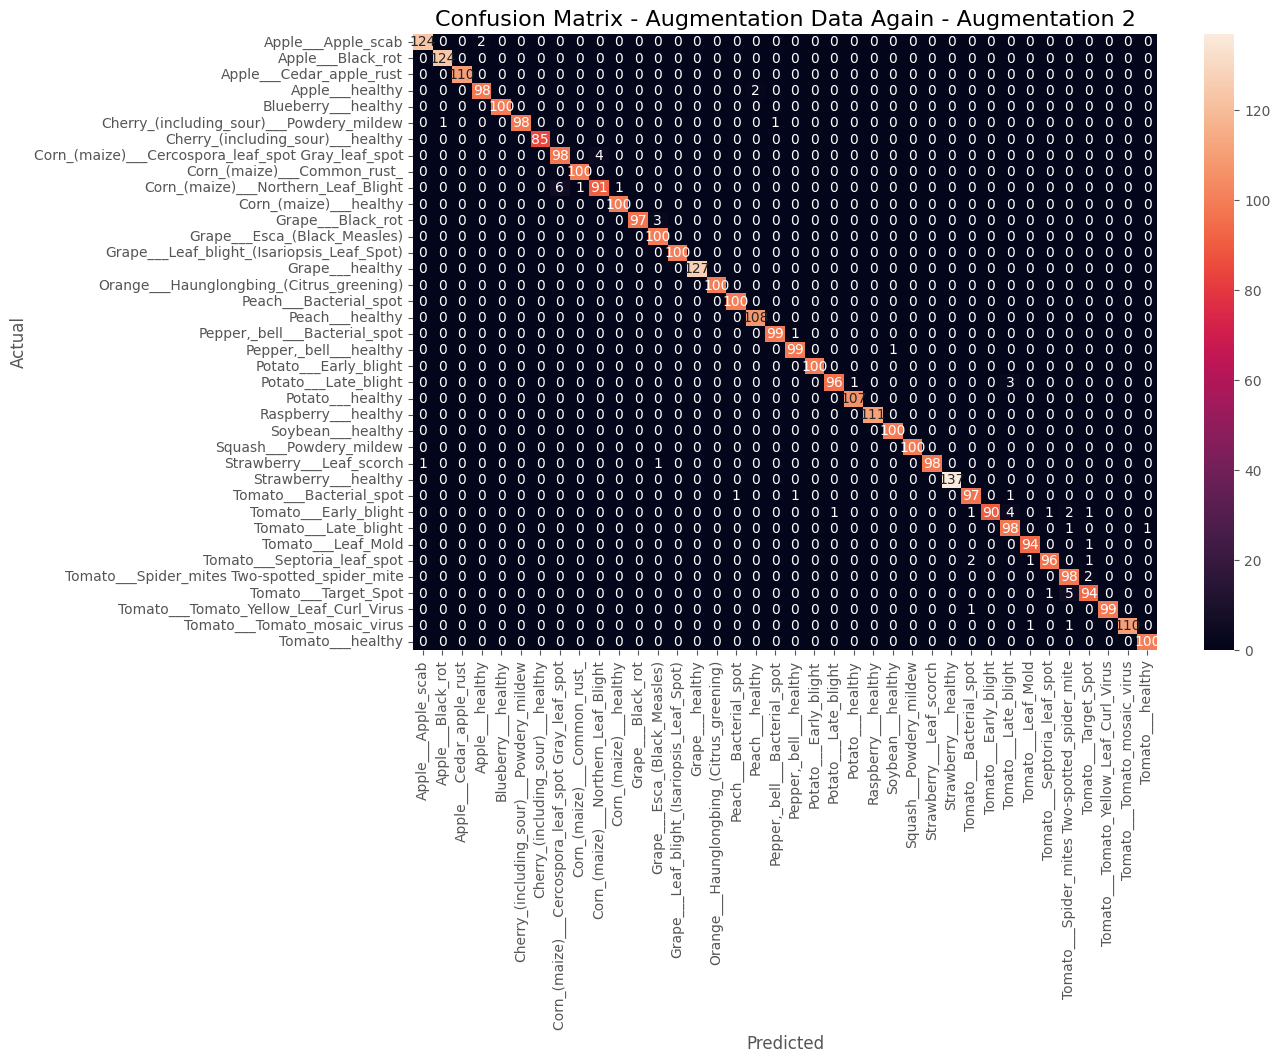

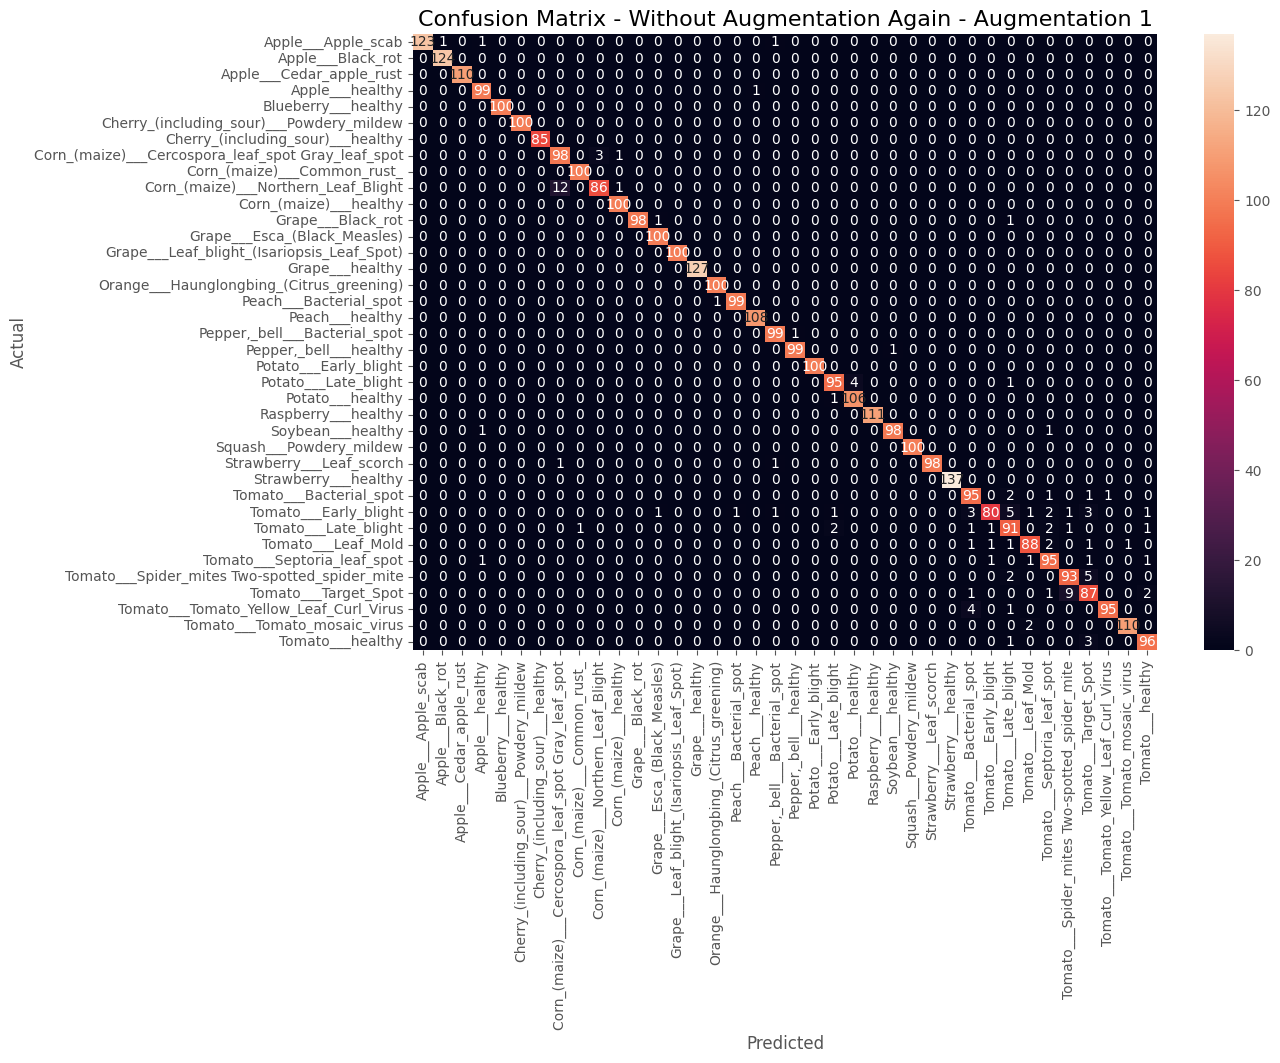

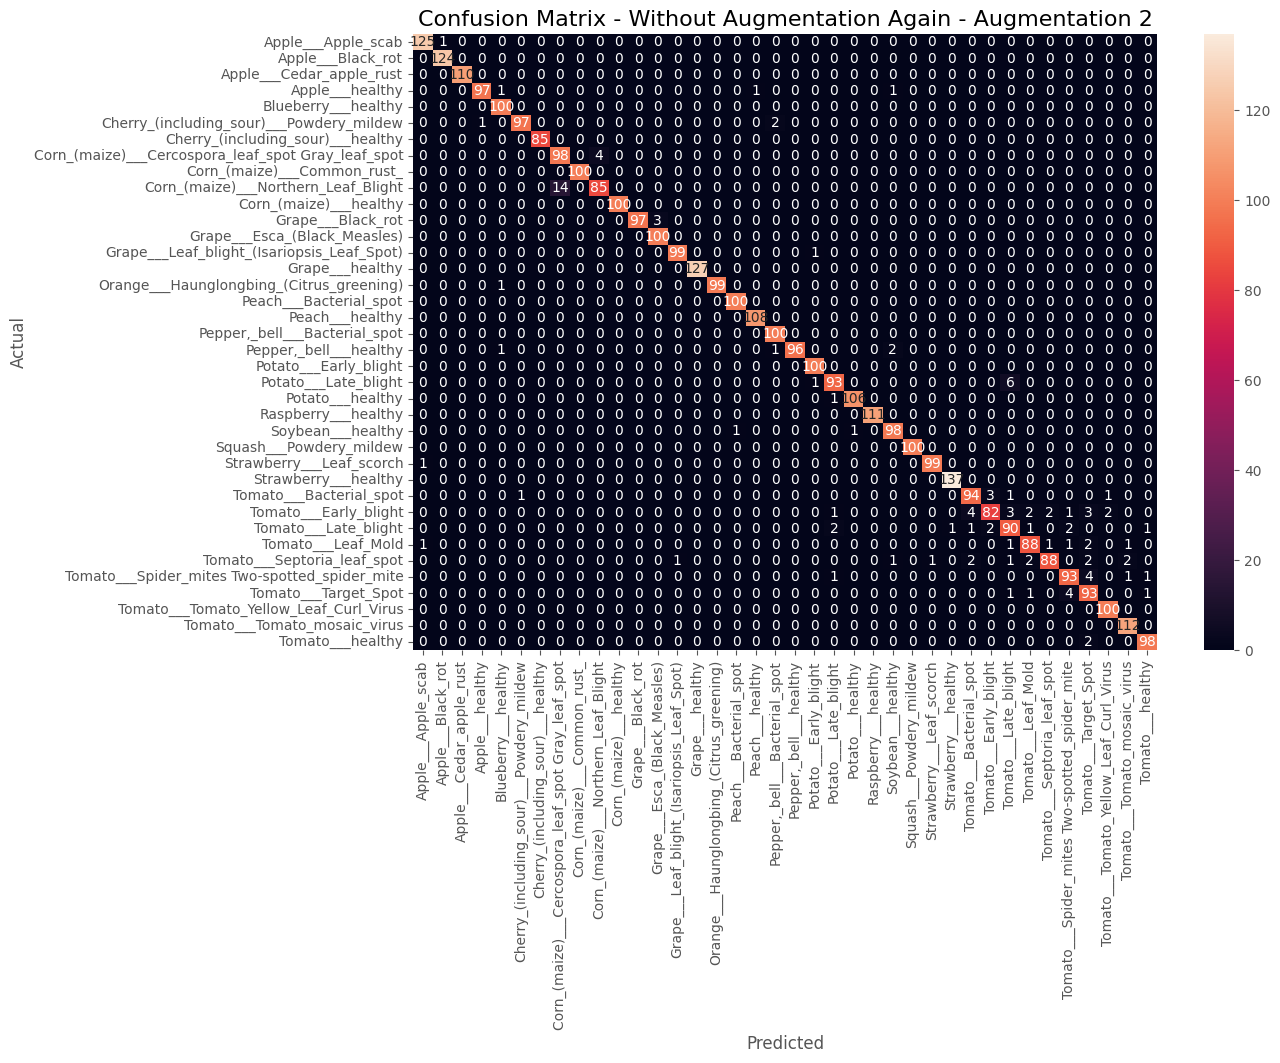

In [63]:
def plot_confusion_matrix(y_true, y_pred, labels, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(12, 8))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix - {title}', fontsize=16)
    plt.show()

plot_confusion_matrix(y_true_1, y_pred_aug1, test_generator_1.class_indices.keys(), 'Augmentation Data Again - Augmentation 1')
plot_confusion_matrix(y_true_2, y_pred_aug2, test_generator_2.class_indices.keys(), 'Augmentation Data Again - Augmentation 2')
plot_confusion_matrix(y_true_1, y_pred_without_aug1, test_generator_1.class_indices.keys(), 'Without Augmentation Again - Augmentation 1')
plot_confusion_matrix(y_true_2, y_pred_without_aug2, test_generator_2.class_indices.keys(), 'Without Augmentation Again - Augmentation 2')

In [64]:
def classification_report_dataframe(y_true, y_pred, labels):
    cr = classification_report(y_true, y_pred, target_names=labels, output_dict=True)
    cr_df = pd.DataFrame(cr).transpose()
    return cr_df

cr_df_aug1 = classification_report_dataframe(y_true_1, y_pred_aug1, test_generator_1.class_indices.keys())
cr_df_aug2 = classification_report_dataframe(y_true_2, y_pred_aug2, test_generator_2.class_indices.keys())
cr_df_without_aug1 = classification_report_dataframe(y_true_1, y_pred_without_aug1, test_generator_1.class_indices.keys())
cr_df_without_aug2 = classification_report_dataframe(y_true_2, y_pred_without_aug2, test_generator_2.class_indices.keys())

print('Augmentation Data Again - Augmentation 1\n-------------------------------------\n',cr_df_aug1,end="\n\n")
print('Augmentation Data Again - Augmentation 2\n-------------------------------------\n',cr_df_aug2,end="\n\n")
print('Without Augmentation Again - Augmentation 1\n-------------------------------------\n', cr_df_without_aug1,end="\n\n")
print('Without Augmentation Again - Augmentation 2\n-------------------------------------\n', cr_df_without_aug2,end="\n\n")

Augmentation Data Again - Augmentation 1
-------------------------------------
                                                     precision    recall  \
Apple___Apple_scab                                   1.000000  0.976190   
Apple___Black_rot                                    1.000000  1.000000   
Apple___Cedar_apple_rust                             1.000000  1.000000   
Apple___healthy                                      0.961538  1.000000   
Blueberry___healthy                                  1.000000  1.000000   
Cherry_(including_sour)___Powdery_mildew             1.000000  0.990000   
Cherry_(including_sour)___healthy                    1.000000  1.000000   
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot   0.889908  0.950980   
Corn_(maize)___Common_rust_                          1.000000  1.000000   
Corn_(maize)___Northern_Leaf_Blight                  0.945652  0.878788   
Corn_(maize)___healthy                               0.990099  1.000000   
Grape___Black_rot   

#### The “data augmentation again” models (augmentation 1 and 2) both have an accuracy around 98%. Augmentation 1 uses more types of augmentation (like shear, zoom, and shift), which can make the model more robust. However, real-world data is not likely to have so much variation. Augmentation 2 (with augmentations like horizontal flip, vertical flip, and rotation) is chosen because it is still robust and better matches the type of data expected in real-world use cases.

#### Based on the confusion matrix, augmentation 1 has trouble predicting 'Corn_(maize)__Northern_Leaf_Blight' in the test data. This is probably because the extra augmentations make it harder for the model to recognize this class correctly.

In [5]:
# from tensorflow.keras.models import load_model

# model_1 = load_model("../Saved_models/_ResNet50V2_without_aug2.h5")
# model_2 = load_model("../Saved_models/_ResNet50V2_without_aug1.h5")
# model_3 = load_model("../Saved_models/_ResNet50V2_aug2.h5")
# model_4 = load_model("../Saved_models/_ResNet50V2_aug1.h5")

# model_1.save("../Saved_models/_1")
# model_2.save("../Saved_models/_2")
# model_3.save("../Saved_models/_3")
# model_4.save("../Saved_models/_4")

INFO:tensorflow:Assets written to: ../Saved_models/1\assets


INFO:tensorflow:Assets written to: ../Saved_models/1\assets


INFO:tensorflow:Assets written to: ../Saved_models/2\assets


INFO:tensorflow:Assets written to: ../Saved_models/2\assets


INFO:tensorflow:Assets written to: ../Saved_models/3\assets


INFO:tensorflow:Assets written to: ../Saved_models/3\assets


INFO:tensorflow:Assets written to: ../Saved_models/4\assets


INFO:tensorflow:Assets written to: ../Saved_models/4\assets


In [9]:
# # Save the best model
# if os.path.exists("../Saved_models/_ResNet50V2_model.h5"):
#     os.remove("../Saved_models/_ResNet50V2_model.h5")
# shutil.copy("../Saved_models/_ResNet50V2_aug1.h5", "../Saved_models/_model_4.h5")

# # shutil.move("../Saved_models/_ResNet50V2_aug1.h5", "../Saved_models/_model_4.h5")
# # os.rename("Saved_models/_ResNet50V2_aug1_copy.h5", "Saved_models/_ResNet50V2_model.h5")

'../Saved_models/model_4.h5'